### First of all, import mnmstpy package

In [1]:
import mnmstpy as mnmst

### The, load data, and pre-process

In [2]:
import scanpy as sc

# adata = sc.read_visium(path='D:/st_projects/data/DLPFC/151675', count_file='151675_filtered_feature_bc_matrix.h5')
adata = sc.read_visium(path='C:/Users/250010198/Program/GitHub/MNMST/Data/151675', count_file='151675_filtered_feature_bc_matrix.h5')
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=3000)
hvg_filter = adata.var['highly_variable']
sc.pp.normalize_total(adata, inplace=True)
adata = adata[:, hvg_filter]
display(adata)

c:\Users\250010198\AppData\Local\miniconda3\envs\mnmst\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\250010198\AppData\Local\miniconda3\envs\mnmst\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\250010198\AppData\Local\miniconda3\envs\mnmst\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


View of AnnData object with n_obs × n_vars = 3592 × 3001
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg'
    obsm: 'spatial'

### Now, users can obtain cell spatial network $W^{[s]}$ by using mnmstpy, and enhance data with just a single line of code

In [3]:
enhanced_adata, cell_spatial = mnmst.data_enhance(adata, k_nei=6)


Median distance to closest cell = 138.00362314084367
num_nbrs: 3001


c:\Users\250010198\AppData\Local\miniconda3\envs\mnmst\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### Using PCA to obtain cell expression feature, and construct the initial graph, to help self-representation learning (SRL)

In [4]:
sc.pp.pca(enhanced_adata)
low_dim_x = enhanced_adata.obsm['X_pca']
init_graph = mnmst.construct_initial_graph(low_dim_x)

### We now construct cell expression network $W^{[e]}$. For speed, we show the code using mnmst-torch version.

In [5]:
import torch

# using torch, you need to convert the numpy object into tensor
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
init_W_tensor = torch.from_numpy(init_graph).float().to(device)
cell_spatia_tensor = torch.from_numpy(cell_spatial.A).float().to(device)
x_tensor = torch.from_numpy(low_dim_x.T).to(device)
# now, calculating the cell expression network
C_gpu = mnmst.sparse_self_representation_torch(x_tensor, init_w=init_W_tensor, device=device)

# Epoch 99, loss: 552.332: 100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


#### After obtaining the cell expression network $W^{[e]}$, MNMST treats both networks as a multi-layer network, aiming to extract the consensus structural relationship among them. This idea is consistent with the concept of **Spatial domain**: "Regions where cells inside are coherent with similar expression profiles and spatial proximity".

In [6]:
# For more details of mnmst, please refer to our paper, and the source code provided in this github repository
Z_gpu = mnmst.MNMST_representation_gpu(C_gpu, cell_spatia_tensor, device=device)
Z = Z_gpu.detach().cpu().numpy()

# Epoch 19, loss: 0.097:  20%|██        | 20/100 [00:09<00:36,  2.19it/s]


C:\Users\250010198\AppData\Local\Temp\ipykernel_23752\2147372089.py:5: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
c:\Users\250010198\AppData\Local\miniconda3\envs\mnmst\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\250010198\AppData\Local\Temp\ipykernel_23752\2147372089.py:14: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, neighbors_key='representation', resolution=1.4, key_added='MNMST_GPU')


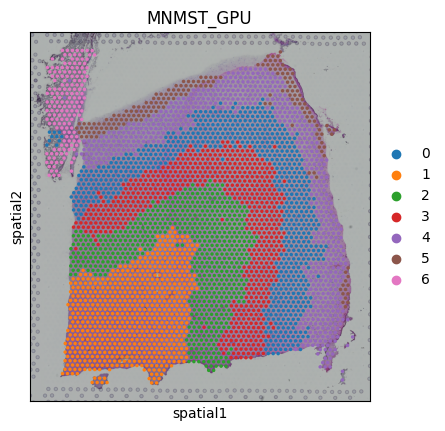

In [7]:
key_added = 'representation'
conns_key = 'representation'
dists_key = 'representation'

adata.uns[key_added] = {}    
representation_dict = adata.uns[key_added]
representation_dict['connectivities_key'] = conns_key
representation_dict['distances_key'] = dists_key
representation_dict['var_names_use'] = adata.var_names.to_numpy()
    
representation_dict['params'] = {}
representation_dict['params']['method'] = 'umap'
adata.obsp['representation'] = Z
sc.tl.leiden(adata, neighbors_key='representation', resolution=1.4, key_added='MNMST_GPU')
sc.pl.spatial(adata, color=['MNMST_GPU'])

### We provide details of our device here

In [8]:
import psutil

cpu_info = f"CPU: {psutil.cpu_count(logical=False)} cores, {psutil.cpu_count()} threads"

gpu_info = "GPU: "
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    for i in range(gpu_count):
        gpu_info += f"GPU {i + 1}: {torch.cuda.get_device_name(i)}, "
    gpu_info = gpu_info[:-2]
else:
    gpu_info += "No GPU available."

print(cpu_info)
print(gpu_info)


CPU: 24 cores, 32 threads
GPU: No GPU available.
